In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)
library(tools)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Comparação de classificadores em fluxos de dados
* Dinaldo Pessoa (dap2)
* Joel Júnior (jalj)
* Geraldo Júnior (gpcj)

# Problema
Quando um classificador em produção apresenta uma piora na performance ou uma nova abordagem é proposta, o analista precisa comparar o classificador atual com o novo para escolher o melhor. Porém, o cenário de fluxos de dados apresenta desafios adicionais ao processamento em lote por não dispor de dados históricos ou esses não serem mais relevantes após mudanças de conceito.

## Dados estacionários balanceados

In [2]:
load_metrics <- function(path) {
    data <- read.table(file=path, header=TRUE, sep=",")
    #print(head(no_drift_balanced))
    metrics <- data %>%
            rename(instance = classified.instances, recall_0 = Recall.for.class.0..percent., recall_1 = Recall.for.class.1..percent.) %>%
            filter(10 <= instance & instance <= 50000) %>%
            select(instance, recall_0, recall_1)
}
plot_metrics_evolution <- function (path) {
    metrics <- load_metrics(path) %>%
            gather("metric", "value", recall_0, recall_1)
    #print(head(metrics))
    ggplot(data = metrics, mapping = aes(x = instance, y = value, color = metric)) +
        geom_line()
}

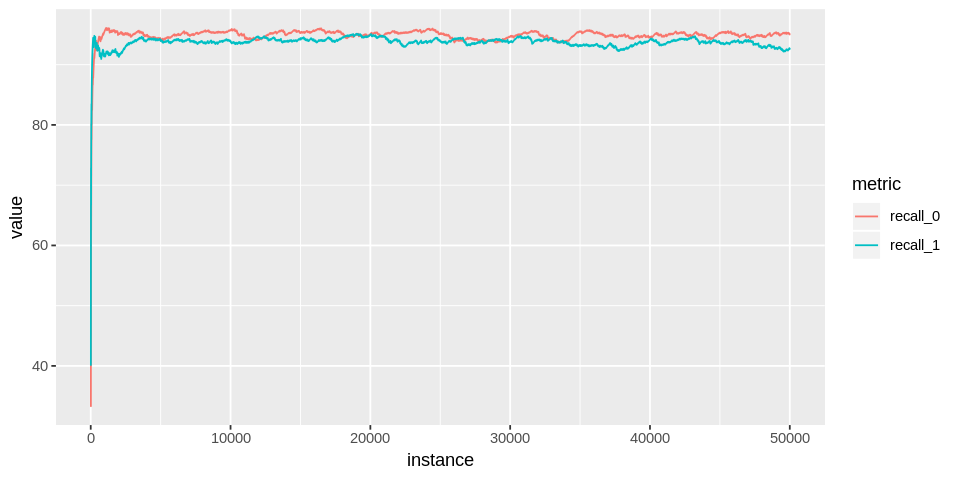

In [3]:
options(repr.plot.width=8, repr.plot.height=4)
plot_metrics_evolution("../data/evaluation/naive_bayes/no_drift_balanced.csv")

$P(y|X) = P(X|y)P(y)$

## Mudança na verossimilhança

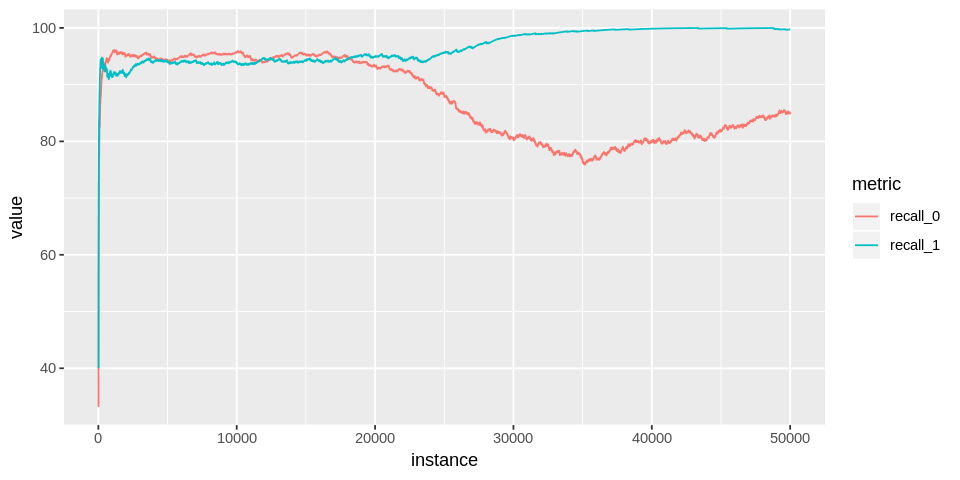

In [4]:
plot_metrics_evolution("../data/evaluation/naive_bayes/maximum_likelihood_drift.csv")

$P(y|X) = \underline{P(X|y)}P(y)$

## Mudança na probabilidade a priori

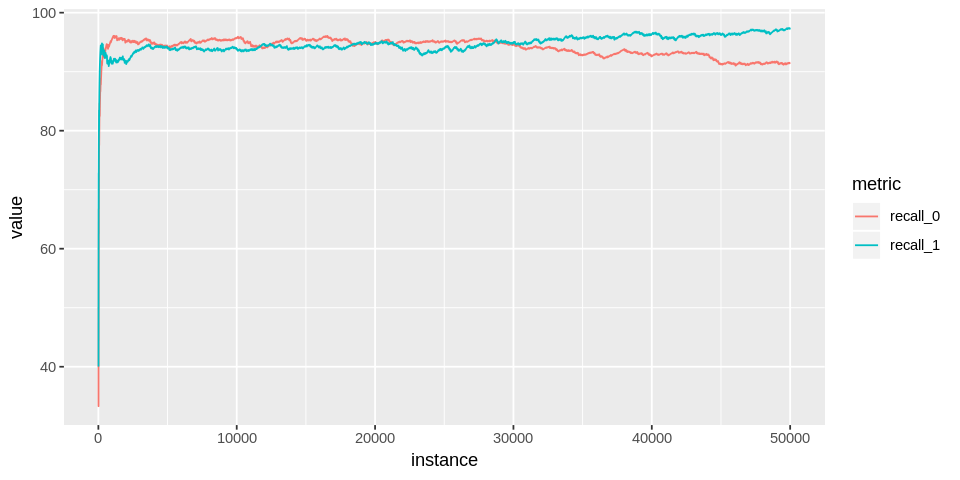

In [5]:
plot_metrics_evolution("../data/evaluation/naive_bayes/a_priori_drift.csv")

$P(y|X) = P(X|y)\underline{P(y)}$

## Bases de dados
* Origem: Sintéticas e reais
* Domínio: Predição de defeito de software
* Exemplos: commits de repositórios de código fonte
* Features: TODO
* Label: contém bug ou não
<br/>
TODO tabela de sumário para explicar as features? visualização para mostrar o desbalanceamento?

# Objetivo
Comparar dois classificadores no cenário de fluxos de dados com a presença de mudança de conceito para auxiliar o analista a escolher qual deve ser mantido no ambiente de produção.

# Metodologia
## Descrição
* Testa e treina dois classificadores a cada novo exemplo no fluxo de dados.
 * Classificadores: Naive Bayes e OzaBagASHT.
* Calcular, **para cada classe**, uma tabela de contingência que conta acertos e erros de cada classificador.
 * Métrica: um recall por classe
 * Contagem na forma prequencial com fading factor 0,999.
* Aplicar dois testes de McNemar com base nas duas tabelas de contingência.
 * alfa: 0,05
* O classificador que vencer em mais testes é mantido em produção.

## Hipóteses
* $H_0: recall_1 = recall_2$
* $H_1: recall_1 \neq recall_2$

# Resultados
## Dados sintéticos

In [6]:
delta_2_hit <- function(current_metric, previous_metric) {
    return(sign(current_metric - previous_metric))
}
load_hit <- function(classifier, dataset) {
    path = sprintf("../data/evaluation/%s/%s.csv", classifier, dataset)
    metric <- load_metrics(path) %>%
            mutate(previous_instance = instance - 1)
    #print(head(metric))
    hit <- merge(metric, metric, by.x = "previous_instance", by.y = "instance") %>%
            transmute(instance = instance, hit_0 = delta_2_hit(recall_0.x, recall_0.y), hit_1 = delta_2_hit(recall_1.x, recall_1.y))
    return(hit)
}
calculate_p_value <- function(hits, column_classifier_1, column_classifier_2, column_p_value) {
    fading_factor = 0.999
    contingency_table = matrix(c(0, 0, 0, 0),
           nrow = 2,
           dimnames = list("Classsifier 1" = c("Hit", "Miss"),
                           "Classifier 2" = c("Hit", "Miss")))
    p_value <- hits %>%
                mutate(column_p_value := 0)
    for (row in 1:nrow(hits)) {
    #for (row in 1:100) {
        hit.classifier_1 <- hits[row, column_classifier_1]
        hit.classifier_2 <- hits[row, column_classifier_2]

        if (abs(hit.classifier_1) == 1 & abs(hit.classifier_2) == 1) {
            #print(contingency_table)
            contingency_table["Hit", "Hit"] = fading_factor * contingency_table["Hit", "Hit"]
            contingency_table["Hit", "Miss"] = fading_factor * contingency_table["Hit", "Miss"]
            contingency_table["Miss", "Hit"] = fading_factor * contingency_table["Miss", "Hit"]
            contingency_table["Miss", "Miss"] = fading_factor * contingency_table["Miss", "Miss"]
        }

        if (hit.classifier_1 == 1 & hit.classifier_2 == 1) {
            contingency_table["Hit", "Hit"] = contingency_table["Hit", "Hit"] + 1
        } 
        if (hit.classifier_1 == 1 & hit.classifier_2 == -1) {
            contingency_table["Hit", "Miss"] = contingency_table["Hit", "Miss"] + 1
            }
        if (hit.classifier_1 == -1 & hit.classifier_2 == 1) {
            contingency_table["Miss", "Hit"] = contingency_table["Miss", "Hit"] + 1
        }
        if (hit.classifier_1 == -1 & hit.classifier_2 == -1) {
            contingency_table["Miss", "Miss"] = contingency_table["Miss", "Miss"] + 1
        }
        result <- mcnemar.test(contingency_table)

        p_value[row, column_p_value] <- 100 * unlist(result[3], use.names = FALSE)
    }
    p_value <- p_value %>%
                select(instance, !!column_p_value)
    return(p_value)
}
load_p_value <- function(dataset) {    
    classifier_1 <- load_hit("naive_bayes", dataset)
    classifier_2 <- load_hit("oza_bag_asht", dataset)
    hits <- merge(classifier_1, classifier_2, by = "instance") %>%
                        rename(hit_0.classifier_1 = hit_0.x, hit_1.classifier_1 = hit_1.x, hit_0.classifier_2 = hit_0.y, hit_1.classifier_2 = hit_1.y)
    validation <- hits %>%
                    filter(abs(hit_0.classifier_1) != abs(hit_0.classifier_2) | abs(hit_1.classifier_1) != abs(hit_1.classifier_2))
    #print(sprintf("This number must be zero: %s", nrow(validation)))
    p_value_0 <- calculate_p_value(hits, "hit_0.classifier_1", "hit_0.classifier_2", "p_value_0")
    p_value_1 <- calculate_p_value(hits, "hit_1.classifier_1", "hit_1.classifier_2", "p_value_1")
    p_value <- p_value_0 %>%
                merge(p_value_1, by = "instance")
    return(p_value)
}
plot_comparison <- function(dataset) {
    classifier_1 = "naive_bayes"
    classifier_2 = "oza_bag_asht"
    p_value <- load_p_value(dataset)
    metrics_classifier_1 <- load_metrics(sprintf("../data/evaluation/%s/%s.csv", classifier_1, dataset))
    metrics_classifier_2 <- load_metrics(sprintf("../data/evaluation/%s/%s.csv", classifier_2, dataset))
    comparison <- p_value %>%
                    merge(metrics_classifier_1, by = "instance") %>%
                    merge(metrics_classifier_2, by = "instance") %>%
                    rename(recall_0.classifier_1 = recall_0.x, recall_1.classifier_1 = recall_1.x, recall_0.classifier_2 = recall_0.y, recall_1.classifier_2 = recall_1.y)
    recall.classifier_1 = sprintf("recall %s", classifier_1)
    recall.classifier_2 = sprintf("recall %s", classifier_2)
    comparison_0 <- comparison %>%
                       select(instance, p_value = p_value_0, !!recall.classifier_1 := recall_0.classifier_1, !!recall.classifier_2 := recall_0.classifier_2) %>%
                       mutate(class = "class 0")
    comparison_1 <- comparison %>%
                       select(instance, p_value = p_value_1, !!recall.classifier_1 := recall_1.classifier_1, !!recall.classifier_2 := recall_1.classifier_2) %>%
                       mutate(class = "class 1")
    comparison <- comparison_0 %>%
                    union(comparison_1) %>%
                    gather("metric", "value", p_value, !!recall.classifier_1, !!recall.classifier_2)
    suppressWarnings(print(ggplot(data = comparison, mapping = aes(x = instance, y = value, color = metric)) +
            ggtitle(toTitleCase(gsub("_", " ", dataset))) +
            geom_line() +
            geom_hline(yintercept=0.05, linetype="dashed") +
            facet_grid(class ~ .)))
}

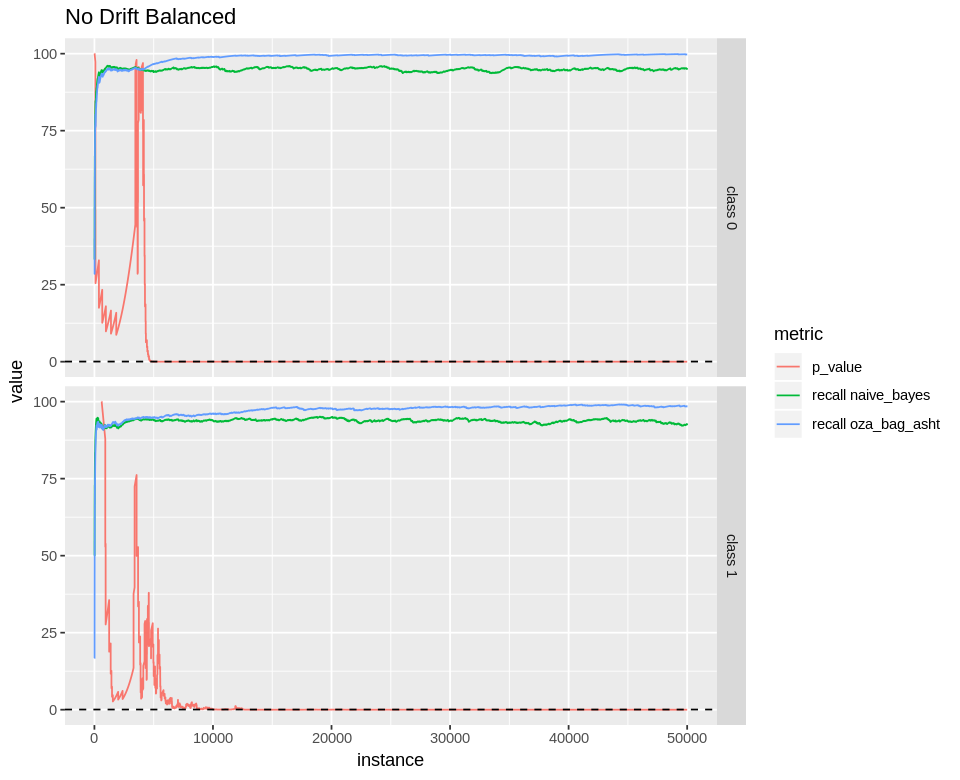

In [7]:
options(repr.plot.width=8, repr.plot.height=6.5)
plot_comparison("no_drift_balanced")

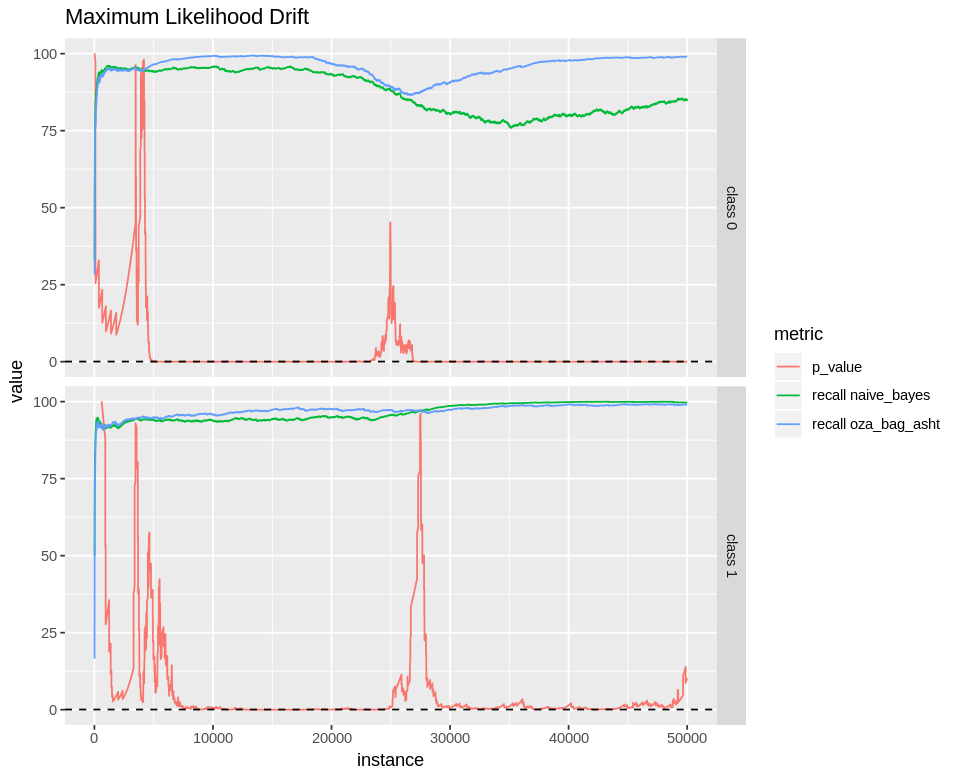

In [8]:
plot_comparison("maximum_likelihood_drift")

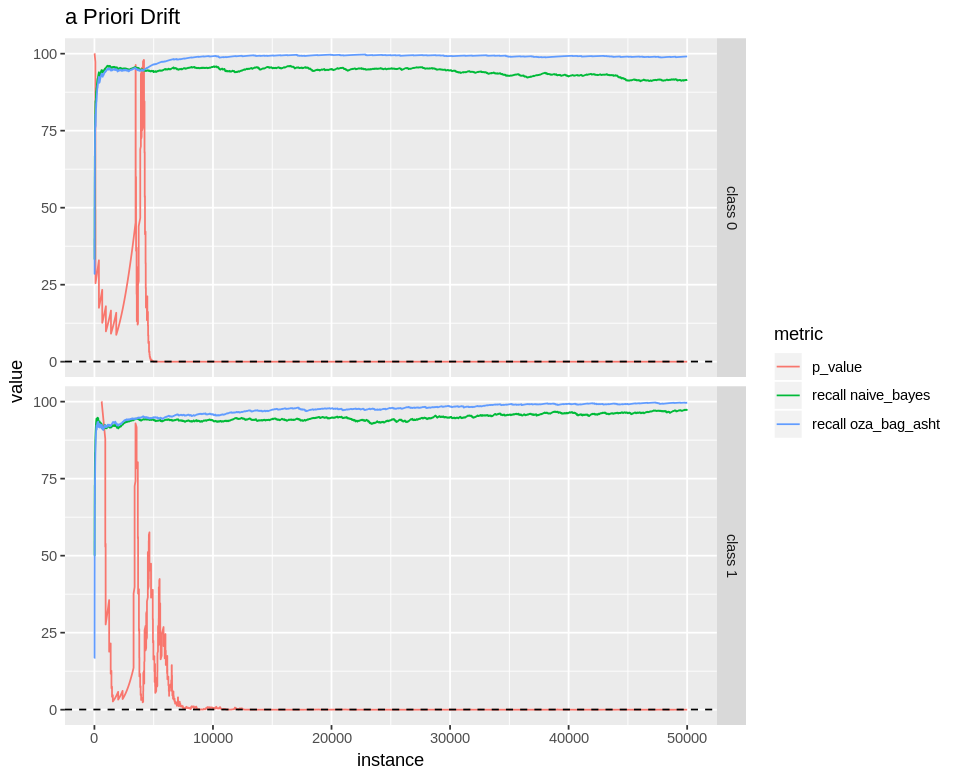

In [9]:
plot_comparison("a_priori_drift")

## Dados reais

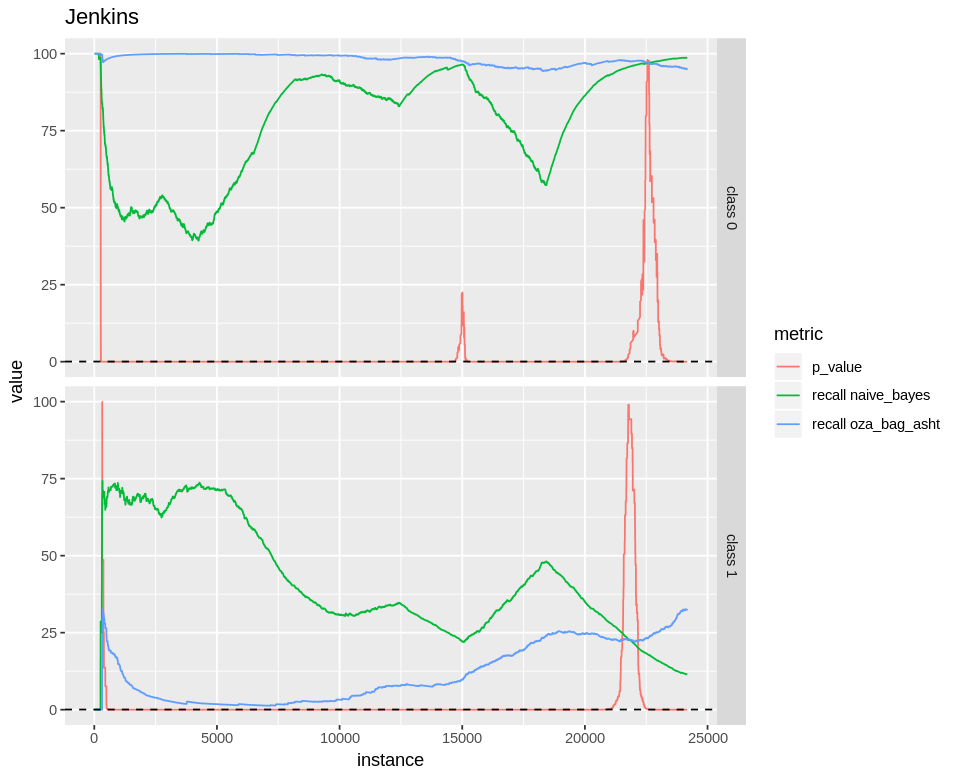

In [10]:
plot_comparison("jenkins")

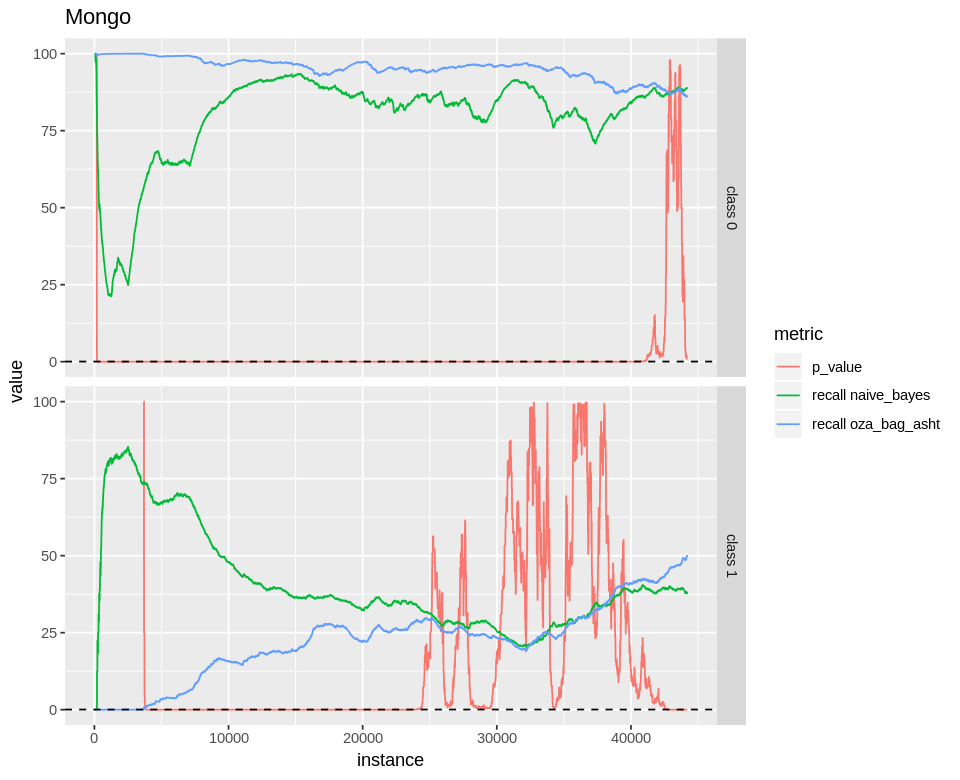

In [11]:
plot_comparison("mongo")

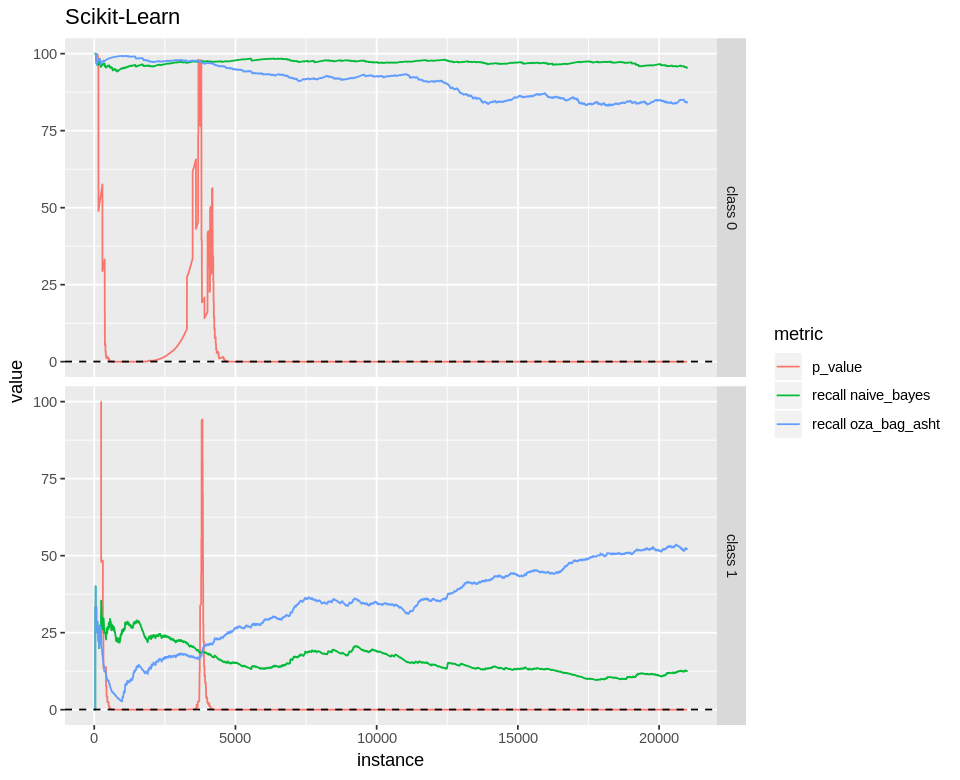

In [12]:
plot_comparison("scikit-learn")

# Conclusão
A metodologia aplicada permitiu a comparação entre os classificadores no cenários de fluxo de dados, mas ocorreram muitos empates nos conjuntos de dados reais. Dessa forma, é preciso definir um critério de desempate. Por exemplo, a média geométrica dos dois recalls.